In [5]:

# ================= Imports =================
import os, math
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import cv2



In [7]:

# ================= Config =================
IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

HC_MEAN = 180.0
HC_STD = 15.0


In [8]:


class ResizeWithPad:
    """
    Resize image while preserving aspect ratio, then pad to (size x size)
    """
    def __init__(self, size=256):
        self.size = size

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            img = TF.to_pil_image(img)

        w, h = img.size

        scale = self.size / max(w, h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_w = self.size - new_w
        pad_h = self.size - new_h

        padding = (
            pad_w // 2,
            pad_h // 2,
            pad_w - pad_w // 2,
            pad_h - pad_h // 2
        )

        img = TF.pad(img, padding, fill=0)

        return img


# ---------------- IMAGE TRANSFORMS (TRAIN + TEST) ----------------
img_tfms = transforms.Compose([
    ResizeWithPad(256),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# ---------------- MASK TRANSFORMS ----------------
mask_tfms = transforms.Compose([
    ResizeWithPad(256),
    transforms.ToTensor()
])


In [9]:

def load_and_fill_mask(mask_pil):
    """
    mask_pil: PIL Image (grayscale)
    returns: PIL Image with filled ellipse mask
    """
    # Convert PIL → numpy
    mask = np.array(mask_pil)

    # Binarize
    _, bin_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(
        bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Fill contours
    filled = np.zeros_like(bin_mask)
    cv2.drawContours(filled, contours, -1, 255, thickness=-1)

    # Back to PIL
    return Image.fromarray(filled)

In [10]:

class TrainDataset(Dataset):
    def __init__(self, img_dir, csv_path):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ---- paths ----
        img_path = os.path.join(self.img_dir, row["filename"])
        mask_path = img_path.replace(".png", "_Annotation.png")
        
        # ---- load ----
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        mask = load_and_fill_mask(mask)
        orig_w, orig_h = img.size
        # ---- transforms ----
        img = img_tfms(img)
        mask = mask_tfms(mask)

        # ---- labels ----
        hc = torch.tensor(row["head circumference (mm)"], dtype=torch.float32)
        pixel_size = torch.tensor(row["pixel size(mm)"], dtype=torch.float32)
        return img, mask, hc, pixel_size, orig_w, orig_h

In [11]:

class TestDataset(Dataset):
    def __init__(self, img_dir):
        self.files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.img_dir = img_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img = Image.open(os.path.join(self.img_dir, fname)).convert("RGB")
        img = img_tfms(img)
        return img, fname


In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [13]:

class ResNetUNet(nn.Module):
    def __init__(self, out_size=256):
        super().__init__()
        self.out_size = out_size

        resnet = models.resnet34(pretrained=True)

        # ---------------- Encoder ----------------
        self.enc1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )                     # 64, 128x128

        self.enc2 = nn.Sequential(
            resnet.maxpool,
            resnet.layer1
        )                     # 64, 64x64

        self.enc3 = resnet.layer2   # 128, 32x32
        self.enc4 = resnet.layer3   # 256, 16x16
        self.enc5 = resnet.layer4   # 512, 8x8

        # ---------------- Decoder ----------------
        self.dec4 = DecoderBlock(512, 256, 256)  # 16x16
        self.dec3 = DecoderBlock(256, 128, 128)  # 32x32
        self.dec2 = DecoderBlock(128, 64, 64)    # 64x64
        self.dec1 = DecoderBlock(64, 64, 32)     # 128x128

        # ---------------- Output ----------------
        self.seg_head = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # -------- Encoder --------
        e1 = self.enc1(x)    # 128x128
        e2 = self.enc2(e1)   # 64x64
        e3 = self.enc3(e2)   # 32x32
        e4 = self.enc4(e3)   # 16x16
        e5 = self.enc5(e4)   # 8x8

        # -------- Decoder --------
        d4 = self.dec4(e5, e4)   # 16x16
        d3 = self.dec3(d4, e3)   # 32x32
        d2 = self.dec2(d3, e2)   # 64x64
        d1 = self.dec1(d2, e1)   # 128x128

        mask = self.seg_head(d1)

        # 🔥 IMPORTANT: upsample to GT size
        mask = F.interpolate(
            mask,
            size=(self.out_size, self.out_size),
            mode="bilinear",
            align_corners=False
        )

        return mask

In [14]:

# ================= Loss & Metrics =================
bce = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([10.0]).to(DEVICE)
)


mse = nn.MSELoss()

def dice(pred, gt):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * gt).sum()
    return (2*inter + 1e-5) / (pred.sum() + gt.sum() + 1e-5)


def iou(pred, gt):
    pred = torch.sigmoid(pred)
    inter = (pred * gt).sum()
    union = pred.sum() + gt.sum() - inter
    return (inter + 1e-5) / (union + 1e-5)

def rmse(p, g):
    return torch.sqrt(torch.mean((p-g)**2))

def mae(p, g):
    return torch.mean(torch.abs(p-g))

def dice_soft(pred, gt):
    pred = torch.sigmoid(pred)
    inter = (pred * gt).sum()
    return (2*inter + 1e-5) / (pred.sum() + gt.sum() + 1e-5)



In [15]:
def train_epoch(model, loader, opt):
    model.train()
    losses = []

    for img, mask, hc, pixel_size,_,_ in loader:
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        p_mask = model(img)

        loss = (
            0.6 * bce(p_mask, mask)
            + 0.4 * (1 - dice_soft(p_mask, mask))
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    return sum(losses) / len(losses)


In [16]:
def evaluate(model, loader):
    model.eval()
    ds, is_ = [], []

    with torch.no_grad():
        for img, mask, _, _, _, _ in loader:
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)

            p_mask = model(img)

            ds.append(dice(p_mask, mask).item())
            is_.append(iou(p_mask, mask).item())

    return sum(ds)/len(ds), sum(is_)/len(is_)


In [17]:

# ================= Visualization =================
def show_sample(dataset, model, idx=0):
    img, mask, hc = dataset[idx]
    model.eval()

    with torch.no_grad():
        pm, ph = model(img.unsqueeze(0).to(DEVICE))

    pm = torch.sigmoid(pm)[0,0].cpu()

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img.permute(1,2,0))
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(mask[0], cmap="gray")
    plt.title("GT Mask")

    plt.subplot(1,3,3)
    plt.imshow(pm, cmap="gray")
    plt.title(f"Pred Mask | HC {ph.item()*HC_STD+HC_MEAN:.1f}")
    plt.show()


In [18]:
full_ds = TrainDataset("training_set", "training_set_pixel_size_and_HC.csv")

from torch.utils.data import random_split

n = len(full_ds)
train_len = int(0.8 * n)
val_len = n - train_len

train_ds, val_ds = random_split(
    full_ds,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,     
    shuffle=False
)


In [42]:
# ================= MAIN =================
model = ResNetUNet(out_size=256).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)


for e in range(EPOCHS):
    loss = train_epoch(model, train_loader, opt)
    d, i = evaluate(model, train_loader)

    print(
        f"Epoch {e+1}: "
        f"Loss {loss:.4f} | "
        f"Dice {d:.3f} | "
        f"IoU {i:.3f}"
    )




c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss 0.4420 | Dice 0.949 | IoU 0.884
Epoch 2: Loss 0.0941 | Dice 0.937 | IoU 0.869
Epoch 3: Loss 0.0664 | Dice 0.971 | IoU 0.911
Epoch 4: Loss 0.0610 | Dice 0.962 | IoU 0.921
Epoch 5: Loss 0.0511 | Dice 0.974 | IoU 0.941
Epoch 6: Loss 0.0460 | Dice 0.970 | IoU 0.937
Epoch 7: Loss 0.0418 | Dice 0.959 | IoU 0.919
Epoch 8: Loss 0.0400 | Dice 0.975 | IoU 0.945
Epoch 9: Loss 0.0382 | Dice 0.974 | IoU 0.944
Epoch 10: Loss 0.0363 | Dice 0.977 | IoU 0.949


In [43]:
torch.save(model.state_dict(), "resnet_unet.pth")


In [19]:
import cv2
import numpy as np
import math

def hc_from_mask(mask):
    """
    mask: numpy array (H, W) binary
    returns HC in pixels
    """
    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    if len(contours) == 0:
        return None

    cnt = max(contours, key=cv2.contourArea)

    ellipse = cv2.fitEllipse(cnt)
    (_, _), (MA, ma), _ = ellipse

    # HC ≈ π * (MA + ma) / 2
    hc_pixels = math.pi * (MA + ma) / 2
    return hc_pixels

def hc_pixels_to_mm(hc_pixels, pixel_size):
    return hc_pixels * pixel_size


In [20]:


def keep_largest_component(mask):
    """
    mask: binary numpy array (0/1 or 0/255)
    returns: binary mask with only largest component
    """
    mask = mask.astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        mask, connectivity=8
    )

    if num_labels <= 1:
        return mask

    # Ignore background (label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    clean = np.zeros_like(mask)
    clean[labels == largest_label] = 1

    return clean


In [46]:
pred_hcs = []
gt_hcs = []

model.eval()
with torch.no_grad():
    for img, mask, gt_hc, pixel_size, orig_w, orig_h in val_loader:
        img = img.to(DEVICE)

        pixel_size = pixel_size.item()
        orig_w = orig_w.item()
        orig_h = orig_h.item()

        pred = model(img)
        pred = (torch.sigmoid(pred)[0,0] > 0.5).cpu().numpy()

        pred = keep_largest_component(pred)

        hc_pixels_resized = hc_from_mask(pred)
        if hc_pixels_resized is None:
            continue

        # 🔥 SCALE BACK TO ORIGINAL IMAGE
        scale = max(orig_w, orig_h) / 256.0
        hc_pixels_original = hc_pixels_resized * scale

        hc_mm = hc_pixels_original * pixel_size

        pred_hcs.append(hc_mm)
        gt_hcs.append(gt_hc.item())


pred_hcs = torch.tensor(pred_hcs)
gt_hcs = torch.tensor(gt_hcs)

print("HC RMSE:", rmse(pred_hcs, gt_hcs).item())
print("HC MAE :", mae(pred_hcs, gt_hcs).item())


HC RMSE: 4.885196685791016
HC MAE : 3.4488837718963623


In [21]:
import cv2
import numpy as np

def mask_to_contour(mask):
    """
    mask: torch.Tensor or numpy array (H,W) binary
    returns: contour image (H,W) with 1-pixel outline
    """
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    contour_img = np.zeros_like(mask)
    cv2.drawContours(contour_img, contours, -1, 255, thickness=2)

    return contour_img


In [22]:
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean


In [49]:
def show_gt_vs_pred(dataset, model, idx=0):
    model.eval()

    # 👇 updated unpacking (6 values now)
    img, gt_mask, _, _, _, _ = dataset[idx]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(DEVICE))
        pred = torch.sigmoid(pred)[0,0] > 0.5

    # ---- Prepare image ----
    img_vis = unnormalize(img.cpu())
    img_np = img_vis.permute(1,2,0).numpy()
    img_np = np.clip(img_np, 0, 1)

    # ---- Prepare masks ----
    gt_np = gt_mask[0].cpu().numpy()
    pred_np = pred.cpu().numpy()

    gt_contour = mask_to_contour(gt_np)
    pred_contour = mask_to_contour(pred_np)

    # ---- Plot ----
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(img_np)
    plt.imshow(gt_contour, cmap="Reds", alpha=0.8)
    plt.title("GT Mask (Outline)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img_np)
    plt.imshow(pred_contour, cmap="Blues", alpha=0.8)
    plt.title("Predicted Mask (Outline)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


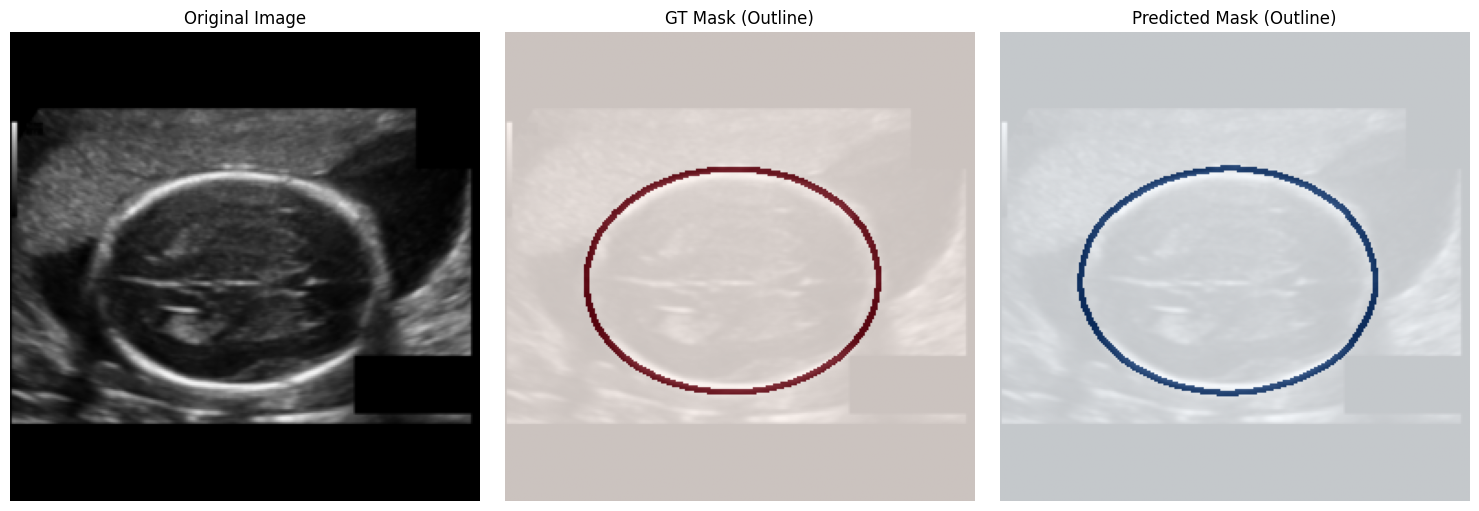

In [50]:
show_gt_vs_pred(train_ds, model, idx=2)


In [27]:
model = ResNetUNet(out_size=256).to(DEVICE)
model.load_state_dict(torch.load("resnet_unet.pth", map_location=DEVICE))
model.eval()


c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\yasha\AppData\Local\Temp\ipykernel_7332\1055865581.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://gith

ResNetUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [23]:
test_ds = TestDataset("test_set")
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


In [24]:
import cv2
import numpy as np

def mask_to_contour(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    contour_img = np.zeros_like(mask)
    cv2.drawContours(contour_img, contours, -1, 255, thickness=2)

    return contour_img


In [25]:
import cv2
import numpy as np

def filled_mask_to_outline(mask, thickness=2):
    """
    mask: numpy array (H, W), 0/255
    returns: outline-only mask
    """
    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    outline = np.zeros_like(mask)
    cv2.drawContours(outline, contours, -1, 255, thickness)

    return outline


In [28]:
import os
os.makedirs("test_predictions", exist_ok=True)

with torch.no_grad():
    for img, fname in test_loader:
        img = img.to(DEVICE)

        pred = model(img)
        pred = torch.sigmoid(pred)[0, 0]
        pred_bin = (pred > 0.5).cpu().numpy().astype("uint8") * 255

        # 🔥 convert to outline
        pred_outline = filled_mask_to_outline(pred_bin, thickness=2)

        out_path = os.path.join("test_predictions", fname[0])
        Image.fromarray(pred_outline).save(out_path)

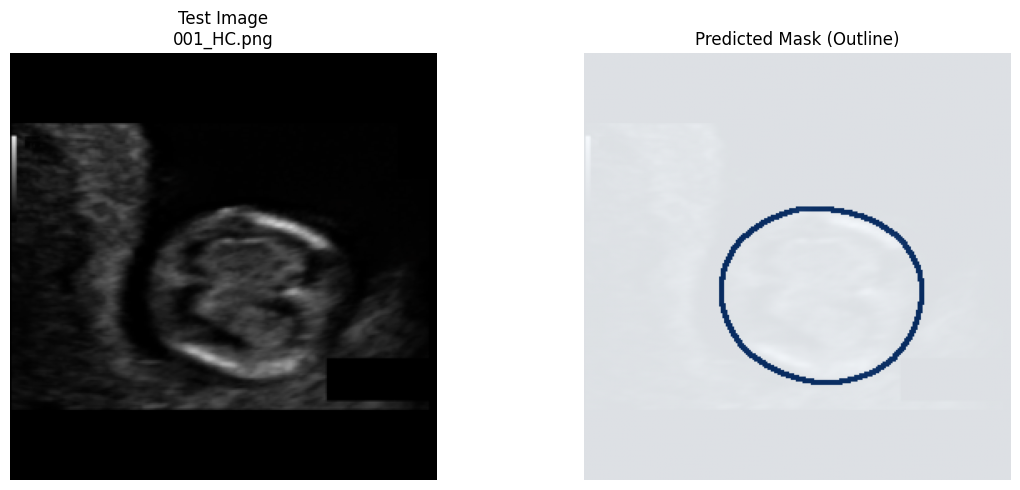

In [29]:
import matplotlib.pyplot as plt

def show_test_image_vs_prediction(test_ds, model, idx=0):
    model.eval()

    img, fname = test_ds[idx]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(DEVICE))
        pred = torch.sigmoid(pred)[0,0] > 0.5

    # Prepare image for display
    img_vis = unnormalize(img.cpu())
    img_np = img_vis.permute(1,2,0).numpy()
    img_np = np.clip(img_np, 0, 1)

    # Predicted outline
    pred_contour = mask_to_contour(pred)

    plt.figure(figsize=(12,5))

    # Left: test image
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title(f"Test Image\n{fname}")
    plt.axis("off")

    # Right: test prediction
    plt.subplot(1,2,2)
    plt.imshow(img_np)
    plt.imshow(pred_contour, cmap="Blues", alpha=0.9)
    plt.title("Predicted Mask (Outline)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


show_test_image_vs_prediction(test_ds, model, idx=1)

